In [97]:
import numpy as np
import random
from get_loader import get_loader
import matplotlib

from models import *
from utils import *

import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import seaborn as sns
import pandas as pd
from kfac import KFAC

In [98]:
# plt.style.use('ggplot')
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 10  
fig_size[1] = 8  
plt.rcParams["figure.figsize"] = fig_size  
plt.rcParams.update({'font.size': 20})

In [99]:
class args:
    batch_size=64
    dataset_size=1000
    dataset='svhn'
    estim_size=5000
    model='cnn'
    lr=0.005
    momentum=0.9
    mode='inv'
    rcond=1e-8
    corrupt=0.
    reg=1e-2
    cuda = torch.cuda.is_available()



cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)
N, N_te = min(args.dataset_size, 60000), min(args.dataset_size, 10000)
args.dataset_size = N
args.test_size = N_te

args.device=device
now = datetime.datetime.now()

cpu


In [100]:
train_loader, test_loader = get_loader(args)

Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat
Dataset loaders done


In [101]:



if args.model == 'cnn':
    model = SmallCNN().to(device)
elif args.model == 'cnn_bn':
    model = SmallCNN_BN().to(device)
elif args.model == 'logreg':
    model = LogReg().to(device)
elif args.model == 'mlp':
    model = MLP().to(device)
elif args.model == 'big_mlp':
    model = BigMLP().to(device)
else:
    print('No model recognized')


optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
#optimizer = torch.optim.Adam(model.parameters(), lr = lr)
n_param = sum(p.numel() for p in model.parameters())

folder =\
f'./log/{now.month}_{now.day}/{now.isoformat()}_lr={args.lr}_param={n_param}_N={N}_bs={args.batch_size}_mu={args.momentum}_model={args.model}_n_estim={args.estim_size}'
# writer = SummaryWriter(log_dir=folder)
# for t in range(50000):

The network has 4680 parameters.


In [102]:
param = model.parameters()

def parameters_to_vector(parameters):
    r"""Convert parameters to one vector

    Arguments:
        parameters (Iterable[Tensor]): an iterator of Tensors that are the
            parameters of a model.

    Returns:
        The parameters represented by a single vector
    """
    # Flag for the device where the parameter is located
    param_device = None

    vec = []
    for param in parameters:
        # Ensure the parameters are located in the same device
#         param_device = _check_param_device(param, param_device)

        vec.append(param.cpu().view(-1))
    return torch.cat(vec)

In [103]:
t = 0
total_t = 7000
# model.train()
log_step = 100
eig_list_tr = []
eig_list_te = []


kfac_tic_list = []
low_rank_tic_list = []
gap_list = []
while t <= total_t:
    for data, labels in train_loader:
        data, labels = data.to(args.device), labels.to(args.device)
        y_pred = model(data)

        loss = F.nll_loss(y_pred, labels)
        if t % log_step == 0:
#             model.eval()
            print(t, loss.item())
            loss_tr = compute_loss(args, train_loader, model)
            loss_te = compute_loss(args, test_loader, model)
            gap = (loss_te-loss_tr).item()
            print(f'Loss tr: {loss_tr}, te: {loss_te}')
        
            gap_list.append(gap)
            kfac_tic_list.append(calculate_kfac_tic(args, test_loader, model, 0))
            low_rank_tic_list.append(calculate_low_rank_tic(args, test_loader, model, 1))
#             fr_tr = compute_fisher_rao(args, train_loader, model)
#             fr_te = compute_fisher_rao(args, test_loader, model)
#             #writer.add_scalar( t)
#             #writer.add_scalar( t)

#             sens_tr =  compute_sensitivity(args, train_loader, model)
#             sens_te =  compute_sensitivity(args, test_loader, model)
#             dic = { 'loss/tr': loss_tr.item(),\
#             'loss/te': loss_te.item(),\
#             'loss/gap': gap,\
#             'fisher_rao/tr': fr_tr.item(),\
#             'fisher_rao/te': fr_te.item(),\
#             'sensitivity/tr': sens_tr.item(),\
#             'sensitivity/te': sens_te.item()}
#             for n, m in dic.items():
#                 writer.add_scalar(n, m, t)
#                 experiment.log_metric(n, m, t)
#             model.train()

        if t % log_step  == 0:
            model.eval()
#             print(t, 'gap:', gap)
#             # Gauss Newton
#             Gtr = calculate_gaussnewton(args, train_loader, model)
#             Gte = calculate_gaussnewton(args, test_loader, model)
#             print('Computed Gauss Newton')
#             _, trGtr, _ = stat_mat(Gtr)
#             _, trGte, _ = stat_mat(Gte)

#             # fisher
#             Ftr = calculate_fisher(args, train_loader, model)
#             eig_tr = np.linalg.eigvalsh(Ftr).ravel()
#             eig_list_tr.append(eig_tr)
#             Fte = calculate_fisher(args, test_loader, model)
#             eig_te = np.linalg.eigvalsh(Fte).ravel()
#             eig_list_te.append(eig_te)
            
            
            
#             Fte = calculate_fisher(args, test_loader, model)
#             print('Computed fisher')
#             _, trFtr, _ = stat_mat(Ftr)
#             _, trFte, _ = stat_mat(Fte)
#             # hessian
#             Htr = calculate_hessian(args, train_loader, model)
#             Hte = calculate_hessian(args, test_loader, model)
#             print('Computed hessians')

#             _, trHtr, _ = stat_mat(Htr)
#             _, trHte, _ = stat_mat(Hte)
#             # covariance
#             Ctr = calculate_covariance(args, train_loader, model)
#             Cte = calculate_covariance(args, test_loader, model)
#             print('Computed covariances')
#             _, trCtr, _ = stat_mat(Ctr)
#             _, trCte, _ = stat_mat(Cte)

            model.train()
# 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t += 1
model.eval()



0 2.3204121589660645
Loss tr: 2.314469575881958, te: 2.325032949447632
100 2.2558107376098633
Loss tr: 2.2207751274108887, te: 2.2368640899658203
200 2.219388961791992
Loss tr: 2.199721574783325, te: 2.226418972015381
300 2.181596040725708
Loss tr: 2.1662697792053223, te: 2.205315113067627
400 2.0633373260498047
Loss tr: 2.1098415851593018, te: 2.1583850383758545
500 1.9497065544128418
Loss tr: 2.027989387512207, te: 2.108442783355713
600 1.9015997648239136
Loss tr: 1.943527102470398, te: 2.050548553466797
700 1.9034560918807983
Loss tr: 1.8573306798934937, te: 2.015944004058838
800 1.5303627252578735
Loss tr: 1.7574363946914673, te: 1.9747505187988281
900 1.7468072175979614
Loss tr: 1.655409336090088, te: 1.9042761325836182
1000 1.6105709075927734
Loss tr: 1.549426555633545, te: 1.8414157629013062
1100 1.5588386058807373
Loss tr: 1.435975432395935, te: 1.7835880517959595
1200 1.6615320444107056
Loss tr: 1.3312568664550781, te: 1.7429341077804565
1300 1.3212696313858032
Loss tr: 1.2333

SmallCNN(
  (main): Sequential(
    (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1))
  )
)

In [104]:
gap

4.726095199584961

In [105]:
calculate_kfac_tic(args, test_loader, model)

281.018125

Text(0, 0.5, 'estimated gap')

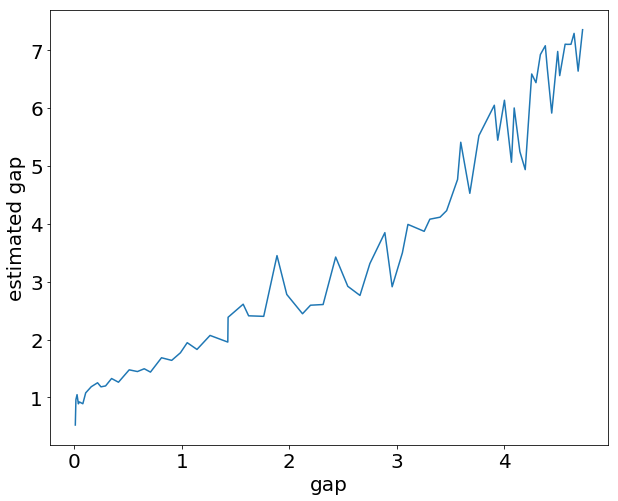

In [116]:
# plt.plot(gap_list, kfac_tic_list)
# plt.plot(gap_list, np.sqrt(np.array(kfac_tic_list)))
plt.plot(gap_list, np.array(low_rank_tic_list))

plt.xlabel('gap')
plt.ylabel('estimated gap')
# plt.plot()
# plt.yscale('log')

Text(0, 0.5, 'gap')

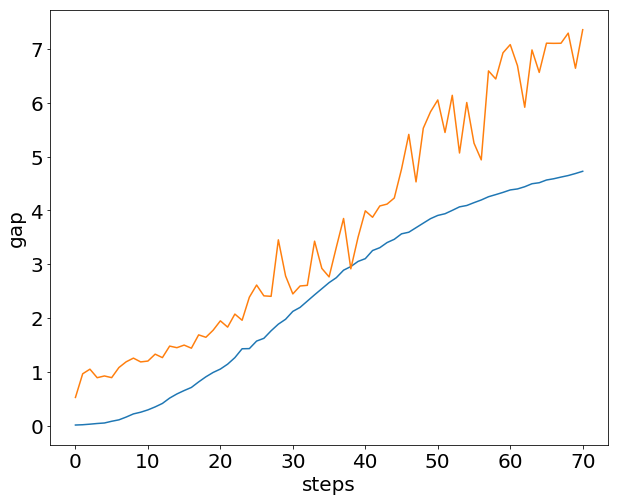

In [114]:
plt.plot(gap_list)
# plt.plot(kfac_tic_list)
# plt.plot(np.sqrt(np.array(kfac_tic_list)))
meas = np.array(low_rank_tic_list)#-np.array(low_rank_tic_list)[0]
plt.plot(meas)
plt.xlabel('steps')
plt.ylabel('gap')
# plt.yscale('log')

In [88]:
Fte = calculate_fisher(args, test_loader, model)

In [89]:
Hte = calculate_hessian(args, test_loader, model)

In [ ]:
Cte = calculate_covariance(args, test_loader, model)

In [ ]:
np.trace(Cte)

In [ ]:
np.trace(Fte)

In [ ]:
np.trace(Hte)

In [ ]:
iFte = np.linalg.pinv(Fte, rcond=1e-3)

In [ ]:
iHte = np.linalg.pinv(Hte, rcond=1e-3)
print(np.trace(iHte))

In [ ]:
np.trace(iFte@Cte)/1000

In [ ]:
np.trace(iHte@Cte)/1000

In [ ]:
from kfac import KFAC
prec = KFAC(model, 0)

In [ ]:
prec

In [ ]:
sum([prec.params[i]['params'][j].sum() for i in range(2) for j in range(2)])

In [ ]:
plt.imshow(prec.params[0]['params'][0].detach())

In [ ]:
gard = torch.autograd.grad(F.nll_loss(model(data), labels), model.parameters())

In [ ]:
len(list(gard))

In [ ]:
prec.params

In [ ]:
torch.sum(gard[0]*gard[0]*prec.params[0]['params'][0])+torch.sum(gard[1]*gard[1]*prec.params[1]['params'][0])+torch.sum(gard[2]*gard[2]*prec.params[0]['params'][1])+torch.sum(gard[3]*gard[3]*prec.params[1]['params'][1])

In [ ]:
res = 0
for i in range(len(gard)):
    res += torch.sum(gard[i]*gard[i]*prec.params[i//2]['params'][i%2])
print(res)

In [ ]:
eps = 0
eig_arr_tr = (np.array(eig_list_tr))
eig_arr_tr += eps
eig_arr_te = (np.array(eig_list_te))
eig_arr_te += eps

In [ ]:
plt.plot(np.arange(13), eig_arr_tr, '+')
plt.yscale('log')
plt.show()


In [ ]:
eps = 1e-10
data_tr = [[int(i), np.log10(np.abs(v)+eps)] for i in range(len(eig_list_tr)) for v in eig_list_tr[i]]
dataset_tr = pd.DataFrame(data_tr, columns = ['step', 'eig'])


In [ ]:
data_te = [[int(i), np.log10(np.abs(v)+eps)] for i in range(len(eig_list_te)) for v in eig_list_te[i]]
dataset_te = pd.DataFrame(data_te, columns = ['step', 'eig'])

In [ ]:
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 20  
fig_size[1] = 12 
plt.rcParams["figure.figsize"] = fig_size  
plt.rcParams.update({'font.size': 20})

In [ ]:
sns.violinplot(data=dataset_tr, x='step', y='eig')

In [ ]:
sns.violinplot(data=dataset_te, x='step', y='eig')

In [ ]:
sns.distplot(eig_list_te[5], bins=150, rug=True, kde=False)
plt.xscale('log')
# plt.yscale('log')

In [ ]:
eig_arr_te[:,-10:].shape

In [ ]:
# plt.plot(eig_arr_tr[:,-100:])

# plt.plot(eig_arr_tr[:,100:200])

plt.plot(eig_arr_tr)
# plt.yscale('log')

In [ ]:
def approx_H1C(args, loader, model, n_est=None, lanbda = 1e-4):
    if n_est is None:
        n_est = args.estim_size
    
    n_param = sum(p.numel() for p in model.parameters())
    C = calculate_covariance(args, loader, model)
    H1C = lanbda*C
    
    n_examples = 0
    for i, (data, labels) in enumerate(loader):
        data, labels = data.to(args.device), labels.to(args.device)
        y_pred = model(data)
        loss = F.nll_loss(y_pred, labels, reduction='sum')/data.size(0)
        n_examples += data.size(0)
        
        temp = []
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True, retain_graph=True)
        grads = torch.cat([g.view(-1) for g in grads])

        for i in range(grads.numel()):
            grad2 = torch.autograd.grad(grads[i], model.parameters(), retain_graph=True)
            grad2 = torch.cat([g.contiguous().view(-1) for g in grad2])
            temp.append(grad2.cpu().numpy())
        H = np.array(temp)
#         print(f'Trace H: {np.trace(H)}' )
        H1C = lanbda*C + (np.eye(n_param) - lanbda*H)@H1C@C
        
        if n_examples > n_est:
            break
    return H1C/lanbda
    

In [ ]:
Htr = calculate_hessian(args, train_loader, model)
Hte = calculate_hessian(args, test_loader, model)
Ctr = calculate_covariance(args, train_loader, model)
Cte = calculate_covariance(args, test_loader, model)

Ftr = calculate_fisher(args, train_loader, model)
Fte = calculate_fisher(args, test_loader, model)

In [ ]:

H1Ctr = np.linalg.pinv(Htr, rcond=1e-3)@Ctr


In [ ]:
n_range = [10, 30, 50, 100, 500, 750, 1000, 1500, 1750, 2000]
H1C_est_list = [approx_H1C(args, train_loader, model, n_est=n_est, lanbda = 1e-4) for n_est in n_range]

In [ ]:
# H1C_est_list

In [ ]:
# plt.axhline(np.trace(H1Ctr), label='H1Ctr')
plt.axhline(np.trace(Htr), label='Htr', c='r')
plt.axhline(np.trace(Ctr), label='Ctr')
plt.plot(np.array(n_range), np.array([np.trace(e) for e in H1C_est_list]), 'o-', label='H1Ctr_est')
# plt.plot(np.array(n_range), np.array([np.trace(e) for e in H1C_est_list]), 'o-', label='H1Ctr_est2')
plt.legend()
plt.yscale('log')

In [ ]:
print(np.trace(Ctr))
print(np.trace(Htr))
print(np.trace(H1Ctr))
# print(np.trace(H1C_est))
print(gap*N)

In [ ]:
wHtr, vHtr = np.linalg.eigh(Htr)
wHte, vHte = np.linalg.eigh(Hte)

In [ ]:
wCtr, vCtr = np.linalg.eigh(Ctr)
wCte, vCte = np.linalg.eigh(Cte)

In [ ]:
mattr = vHtr.T@vCtr
matte = vHte.T@vCte

In [ ]:
plt.imshow(np.log10(np.abs(mattr+1e-8)))

In [ ]:
plt.imshow(np.log10(np.abs(mattr+1e-8)))

In [ ]:
plt.imshow(np.log10(np.abs(matte+1e-8)))

In [ ]:
plt.hist(wHte, bins=50)
plt.yscale('log')
# plt.xscale('log')

In [ ]:
plt.hist(wCte, bins=50)
plt.yscale('log')
# plt.xscale('log')

In [ ]:
plt.semilogx(np.abs(np.diag(matte)[::-1]), label='te')
plt.semilogx(np.abs(np.diag(mattr)[::-1]), label='tr')
plt.legend()

In [ ]:
np.trace(np.linalg.pinv(Htr, rcond=1e-3)@Ctr)/args.dataset_size

In [ ]:
np.trace(np.linalg.pinv(Hte, rcond=1e-3)@Cte)/args.dataset_size

In [ ]:
gap

In [ ]:
np.max(wCte)/np.max(wHte)

In [ ]:
np.max(wCtr)/np.max(wHtr)

In [ ]:
plt.plot((wCtr-wHtr)[::-1], label='tr')
plt.plot((wCte-wHte)[::-1], label='te')
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.xscale('log')
plt.yscale('symlog')
plt.title('Difference of eigenvalues')

In [ ]:
plt.semilogx((wCtr/(1e-4+wHtr))[::-1], label='tr')
plt.semilogx((wCte/(1e-4+wHte))[::-1], label='te')
plt.axhline(y=1, color='r', linestyle='-')
plt.legend()
plt.title('Ratio of eigenvalues')

In [ ]:
print((wCtr/(1e-2+wHtr)).sum())
print((wCte/(1e-2+wHte)).sum())

In [ ]:
np.trace((Htr@Ctr)/(np.linalg.norm(Htr)*np.linalg.norm(Ctr)))

In [ ]:
np.trace((Hte@Cte)/(np.linalg.norm(Hte)*np.linalg.norm(Cte)))

In [ ]:
vec_a = np.linspace(0.1, 9, 100)
vec_norm_te = [(((Cte-a*Hte)**2).sum()/(Cte**2).sum()) for a in vec_a]
vec_norm_tr = [(((Ctr-a*Htr)**2).sum()/(Ctr**2).sum()) for a in vec_a]

In [ ]:
fig, ax=plt.subplots()
plt.plot(vec_a, vec_norm_tr, label='train')
plt.plot(vec_a, vec_norm_te, label='test')
plt.axhline(y=0.1, color='r', linestyle='-')
plt.axhline(y=0.01, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')

ax.set_yticks([0.01, 0.1, 1])

plt.ylabel(r'$\frac{||\mathbf{C}-\alpha \mathbf{H}||^2}{||\mathbf{H}||^2}$')
plt.xlabel(r'$\alpha$')
plt.grid('on')

plt.yscale('log')
plt.legend()

In [ ]:
def parameters_to_vector(parameters):
    r"""Convert parameters to one vector
    Arguments:
        parameters (Iterable[Tensor]): an iterator of Tensors that are the
            parameters of a model.
    Returns:
        The parameters represented by a single vector
    """
    # Flag for the device where the parameter is located
    param_device = None

    vec = []
    for param in parameters:
        # Ensure the parameters are located in the same device
        #param_device = _check_param_device(param, param_device)

        vec.append(param.cpu().view(-1))
    return torch.cat(vec)

In [ ]:
theta = np.array(parameters_to_vector(model.parameters()).detach())

In [ ]:
print(theta.shape)
print(Htr.shape)

In [ ]:
inv_Htr = np.linalg.pinv(Htr, rcond=1e-4)
inv_Hte = np.linalg.pinv(Hte, rcond=1e-4)

In [ ]:
np.trace(inv_Htr)

In [ ]:
frob_sim(inv_Hte, np.outer(theta, theta))

In [ ]:
module = list(model.children())[0]
print(module)

In [ ]:
module[0].weight.svd()

In [ ]:
n = 3
p = 2
f = torch.randn(n, p)
f.requires_grad = True
F.log_softmax(f, dim=1)

In [ ]:
torch.autograd.grad(F.log_softmax(f, dim=1)[0,0], f, retain_graph=True)[0]

In [ ]:
p = 5
n = 10000
mat = np.zeros((p, p))

for i in range(n):
    f = torch.randn(1, p)
    f.requires_grad = True
    
    list_grads = []
    for k in range(p):
        grad = torch.autograd.grad(F.log_softmax(f, dim=1)[0, k], f)[0].squeeze()
        list_grads.append(grad.numpy())
    
    mat += np.array(list_grads)
    
mat /= n

print(mat)

In [ ]:
plt.imshow(mat)
plt.colorbar()

In [ ]:
loader = test_loader
n_param = sum(p.numel() for p in model.parameters())
cov = torch.zeros(n_param, n_param).to(args.device)
n_examples = 0
# mat = np.zeros((10, 10))
matC = np.zeros((10, 10))
matF = np.zeros((10, 10))


scalarsC = []
scalarsF = []
accuracies = []
max_prob = []

for i, (x, y) in enumerate(loader):
    x, y = x.to(args.device), y.to(args.device)
    for t in range(x.size(0)):
        f = model.logits(x[t].unsqueeze(0))
        y_fisher = torch.multinomial(F.softmax(f, dim=-1), 1).squeeze().detach()
        
        prob = F.softmax(f, dim=-1).detach().squeeze().numpy()
    
        list_grads = []
        for k in range(10):
            grad = torch.autograd.grad(F.log_softmax(f, dim=1)[0, k], f)[0].squeeze()
            list_grads.append(grad.numpy())

        g =  np.array(list_grads)
#         print(g)
        
        label_true = y[t].item()
#         print(label_true, y_fisher.item())
        
        elpC = np.outer(g[:,label_true], g[:,label_true])
        elpF = np.outer(g[:,y_fisher], g[:,y_fisher])#np.outer(g@prob, g@prob)
        matC += elpC
        matF += elpF
        scalarsC.append(np.trace(elpC))
        scalarsF.append(np.trace(elpF))
        accuracies.append(np.argmax(prob) == label_true)
        max_prob.append(np.max(prob))
        
    
#         y_pred = model(x[t].unsqueeze(0))
#         loss = F.nll_loss(y_pred, y[t].unsqueeze(0), size_average=False)

#         grads = torch.autograd.grad(loss, model.parameters())
#         grads = torch.cat([g.view(-1) for g in grads])
#         #optimizer.zero_grad()
#         cov += torch.ger(grads, grads).detach()
    n_examples += x.size(0)
#     break
    
#     break
    if n_examples> args.estim_size:
        break

matC /= n_examples
matF /= n_examples

scalarsC = np.array(scalarsC)
scalarsF = np.array(scalarsF)
accuracies = np.array(accuracies)
max_prob = np.array(max_prob)

In [ ]:
plt.imshow(matC)
plt.colorbar()

In [ ]:
plt.imshow(matF)
plt.colorbar()

In [ ]:
plt.hist(scalarsC[np.where(accuracies==False)], bins=50, density=True, label='False')
plt.hist(scalarsC[np.where(accuracies==True)], bins=50, density=True, label='True')
plt.legend()
# plt.yscale('log')

In [ ]:
np.sort(scalarsC)

In [ ]:
plt.hist(scalarsF[np.where(accuracies==False)], bins=50, density=True, label='False')
plt.hist(scalarsF[np.where(accuracies==True)], bins=50, density=True, label='True')
plt.legend()

In [ ]:
plt.hist(max_prob[np.where(accuracies==False)], bins=50, density=True, label='False')
plt.hist(max_prob[np.where(accuracies==True)], bins=50, density=True, label='True')
plt.legend()

In [ ]:
plt.hist( (np.abs((scalarsC-scalarsF)) / np.abs(scalarsC))[np.where(accuracies==False)], bins=50, density=True)
plt.hist( (np.abs((scalarsC-scalarsF)) / np.abs(scalarsC))[np.where(accuracies==True)], bins=50, density=True)
# plt.yscale('log')
# plt.xscale('log')

In [ ]:
sns.kdeplot(scalarsF)
sns.kdeplot(scalarsC)
# plt.yscale('log')

In [ ]:
g[label_true, :]

In [ ]:
label_true

In [ ]:
np.round(prob)

In [ ]:
prob@g

In [ ]:
plt.imshow(g)
plt.colorbar()

In [ ]:
g[:, label_true]

In [ ]:
np.argmax(prob) == label_true

In [ ]:
np.where(accuracies==True)

In [ ]:
plt.imshow(g@g.T)
plt.colorbar()